In [2]:
%pip install --quiet mido numpy scipy matplotlib soundfile
# NOTE: the above command installs the packages used in this notebook.
# If you already have them in your environment you can skip rerunning this cell.

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Standard imports used throughout the notebook
import numpy as np
import matplotlib.pyplot as plt
# `spectrogram` is used for the multi-FFT time-frequency view
from scipy.signal import spectrogram
# `soundfile` is used to write WAV files (optional but convenient)
import soundfile as sf
# `mido` is used to construct and parse simple MIDI files for the polyphonic example
import mido
import os

# Make plots wider by default for readability
plt.rcParams['figure.figsize'] = (10, 4)

In [4]:
# Utilities: conversions and plotting helpers
# - `midi_note_to_freq` converts MIDI note numbers to frequency in Hz
# - `adsr_envelope` provides a very simple envelope to avoid clicks and shape notes
# - plotting helpers create consistent, labeled visualizations

def midi_note_to_freq(m):
    # MIDI note to frequency (A4 = MIDI 69 = 440 Hz) using equal-tempered tuning.
    return 440.0 * 2 ** ((m - 69) / 12.0)

def plot_waveform(signal, sr, title='Waveform', tmin=None, tmax=None):
    # Plot amplitude vs time; optionally focus on a time window with tmin/tmax.
    times = np.arange(len(signal)) / sr
    if tmin is not None and tmax is not None:
        mask = (times >= tmin) & (times <= tmax)
        times = times[mask]
        sig = signal[mask]
    else:
        sig = signal
    plt.figure()
    plt.plot(times, sig, linewidth=0.7)
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_single_fft(signal, sr, title='Single FFT (magnitude)', n_fft=None, freq_limit=5000):
    # Compute a single (global) FFT to show the overall frequency content of `signal`.
    # We apply a Hann window to reduce leakage before taking the FFT.
    x = signal.astype(float)
    if n_fft is None:
        n_fft = len(x)
    X = np.fft.rfft(x * np.hanning(len(x)), n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, 1.0 / sr)
    mag = np.abs(X)
    # For clarity limit the frequency axis to `freq_limit` Hz (fundamentals/harmonics)
    idx = freqs <= freq_limit
    plt.figure()
    plt.plot(freqs[idx], 20 * np.log10(mag[idx] + 1e-12))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(signal, sr, title='Spectrogram', nperseg=1024, noverlap=None, freq_limit=8000):
    # Spectrogram: many short-time FFTs to show frequency content over time.
    if noverlap is None:
        noverlap = nperseg // 2
    f, t, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, noverlap=noverlap, scaling='spectrum')
    # Restrict frequency axis to focus on fundamentals and low harmonics
    fmask = f <= freq_limit
    plt.figure()
    plt.pcolormesh(t, f[fmask], 10 * np.log10(Sxx[fmask, :] + 1e-12), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()
    plt.show()

### ADSR-like Envelope Function

This function generates a simple amplitude envelope that can be applied to any synthesized signal.

**An envelope describes how the amplitude of a sound evolves over time, and it is essential in audio synthesis because it prevents clicks, shapes the character of the sound, and makes synthetic notes feel more “natural.”**

Although this is not a full ADSR envelope, it implements the two most important stages for avoiding abrupt transitions:

- Attack — the signal ramps smoothly from 0 to 1 at the beginning of the note.

- Release — the signal fades out from 1 to 0 at the end of the note.

Between these two phases, the level stays at 1.0 (a fixed sustain).

By multiplying a waveform by this envelope, **we control how the note starts and ends, ensuring smooth boundaries and a more realistic or pleasant sound.**

In [5]:
def adsr_envelope(length, sr, attack=0.01, release=0.05):
    # Very small ADSR-like envelope: linear attack then sustain (1.0) then linear release.
    # Parameters: `length` in seconds, `sr` sample rate, `attack`/`release` in seconds.
    n = int(length * sr)
    env = np.ones(n)
    a = int(attack * sr)
    r = int(release * sr)
    if a > 0:
        env[:a] = np.linspace(0, 1, a)
    if r > 0:
        env[-r:] = np.linspace(1, 0, r)
    return env

## Part 1 — Monophonic synthesis
This section synthesizes a short melody using single sine tones played sequentially (monophonic).
We will show:
- The waveform (time-domain),
- A single global FFT (one FFT over the whole signal) to show frequency content,
- A spectrogram (many FFTs over short windows) to show how frequencies evolve in time.

In [6]:
# Monophonic sequence: list of (midi_note, duration_seconds)
# We use MIDI note numbers for convenience; they are converted to Hz when synthesizing.

def synth_mono_sequence(notes, sr=22050):
    # Synthesize each note as a sine wave, apply a short ADSR envelope and concatenate.
    parts = []
    for note, dur in notes: # Iterate over monophonic sequence
        freq = midi_note_to_freq(note) # Converting MIDI note to Hz
        t = np.linspace(0, dur, int(sr * dur), endpoint=False) # Generates int(sr * dur) evenly spaced time values from 0 up to (but not including) dur
        # Pure sine tone (monophonic), amplitude chosen to avoid clipping when saved
        tone = 0.6 * np.sin(2 * np.pi * freq * t) 
        env = adsr_envelope(dur, sr) # Apply a small attack and release to avoid clicks
        parts.append(tone * env)
    return np.concatenate(parts)

In [7]:
sr = 22050  # sample rate (Hz)
mono_notes = [(64, 0.5), (66, 0.5), (68, 0.5), (69, 1.0), (68, 0.5), (66, 0.5), (64, 1.0)] # Monophonic sequence

# Generate the monophonic signal and save it to `outputs/mono_synthesis.wav`
mono_signal = synth_mono_sequence(mono_notes, sr=sr)
os.makedirs('outputs', exist_ok=True)
sf_path_mono = 'outputs/mono_synthesis.wav'
sf.write(sf_path_mono, mono_signal, sr)

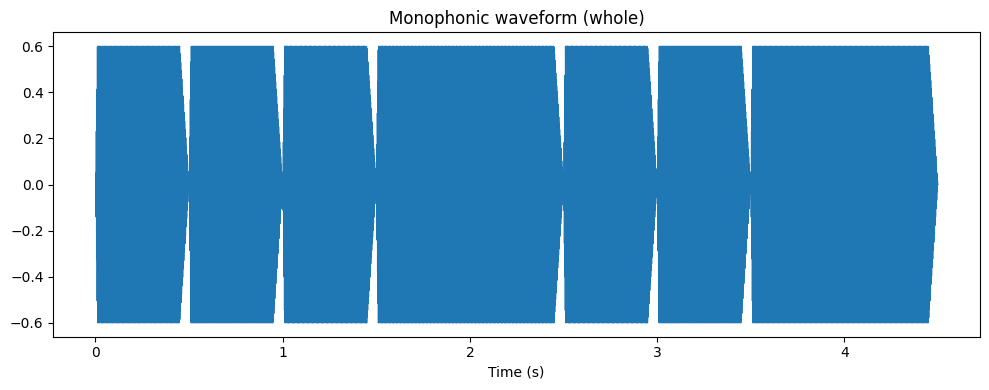

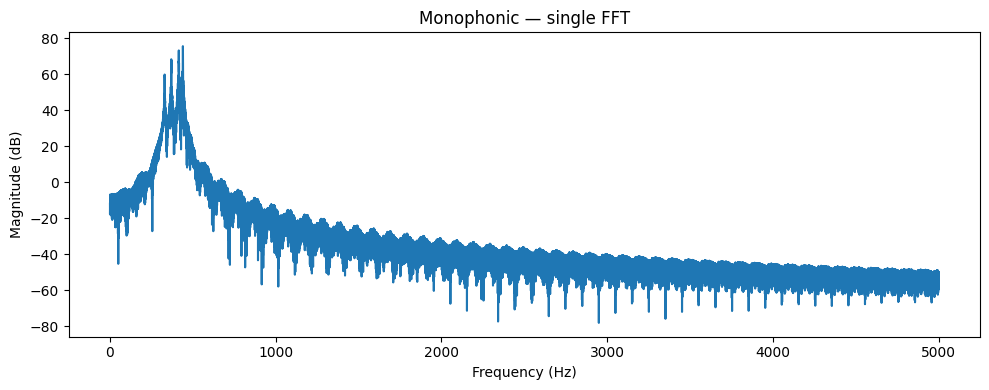

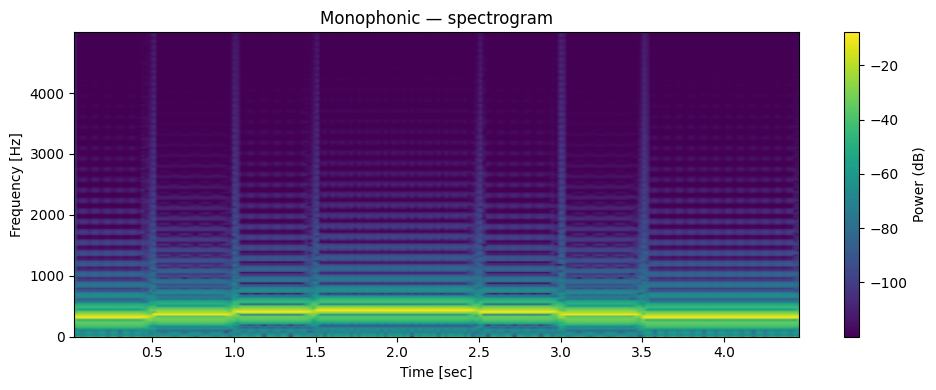

In [8]:
# Visualizations: waveform, single FFT and spectrogram
plot_waveform(mono_signal, sr, title='Monophonic waveform (whole)')
plot_single_fft(mono_signal, sr, title='Monophonic — single FFT')
plot_spectrogram(mono_signal, sr, title='Monophonic — spectrogram', nperseg=1024, freq_limit=5000)

## Part 2 — Polyphonic via MIDI (programmatic)
We will **create a tiny MIDI file** with **overlapping notes** and then synthesize audio by additive synthesis.

**Additive synthesis creates sound by summing many individual sinusoidal components (partials), each with its own frequency, amplitude, and phase.**

The simple MIDI file has a **single track** and **fixed tempo**:

- Single track: all events (notes, instruments, tempo changes…) are stored in a single timeline of events (track)
- Fixed tempo: the speed of the music (tempo) is constant.

Each event has:

- Delta-time: ticks since the last event
- MIDI message: instruction describing what should happen in a musical perfomance (note_on, note_off, etc)

The MIDI is only used for note timing and velocities; the audio is synthesized here with sine waves
so the example is self-contained (no external soundfont required).

The following cells demonstrate how to encode start/end times for overlapping notes (polyphony):

In [9]:
mid = mido.MidiFile() # Creates an empty MIDI (no tracks, events, tempo...)
track = mido.MidiTrack() # Creates a single track where messages will go (not yet part of MIDI file)
mid.tracks.append(track) # Include the track in the MIDI file

# Polyphony is handled inside the same track via overlapping note_on/note_off messages

# Tempo: 120 BPM
tempo = mido.bpm2tempo(120) # MIDI tempo must be in MICROSECONDS PER BEAT, not BPM
track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0)) # meta-event to tell your software how long a beat lasts in real time
ticks_per_beat = mid.ticks_per_beat # specifies how many MIDI ticks correspond to one quarter-note

# Helper: convert seconds to MIDI ticks using the current tempo and ticks_per_beat
# To place a note exactly at 0.5 seconds, 2 seconds, etc., you must convert seconds → ticks.
def seconds_to_ticks(seconds, tempo, ticks_per_beat):
    # tempo is microseconds per beat; convert to seconds per beat first
    us_per_beat = tempo # microseconds per beat
    seconds_per_beat = us_per_beat / 1e6 # convert to seconds
    beats = seconds / seconds_per_beat # number of beats that fit in given seconds
    return int(round(beats * ticks_per_beat)) # returns ticks corresponding to given seconds

# Define a short progression with intentionally overlapping notes (start times/durations)
events = [  # (note, start_s, duration_s, velocity)
    (60, 0.0, 1.0, 100),
    (64, 0.25, 1.0, 100),
    (67, 0.5, 1.0, 100),
    (72, 1.0, 1.5, 100),
    (76, 1.25, 1.0, 100),
    (79, 1.5, 1.0, 100)
]

# Convert these events to note_on/note_off messages with absolute tick times, then to delta times
msgs = []
for note, start, dur, vel in events: # Iterate over each note event
    t_on = seconds_to_ticks(start, tempo, ticks_per_beat) # Convert start time to ticks
    t_off = seconds_to_ticks(start + dur, tempo, ticks_per_beat) # Convert end time to ticks
    msgs.append((t_on, mido.Message('note_on', note=note, velocity=vel, time=0))) # Note on at t_on
    msgs.append((t_off, mido.Message('note_off', note=note, velocity=0, time=0))) # Note off at t_off

# Sorting by absolute tick time:
msgs.sort(key=lambda x: x[0]) # Sort-by first element of tuple (absolute tick time)

print("Sorted messages (absolute tick times):")
for t, msg in msgs:
    print(f"Tick {t}: {msg}")

Sorted messages (absolute tick times):
Tick 0: note_on channel=0 note=60 velocity=100 time=0
Tick 240: note_on channel=0 note=64 velocity=100 time=0
Tick 480: note_on channel=0 note=67 velocity=100 time=0
Tick 960: note_off channel=0 note=60 velocity=0 time=0
Tick 960: note_on channel=0 note=72 velocity=100 time=0
Tick 1200: note_off channel=0 note=64 velocity=0 time=0
Tick 1200: note_on channel=0 note=76 velocity=100 time=0
Tick 1440: note_off channel=0 note=67 velocity=0 time=0
Tick 1440: note_on channel=0 note=79 velocity=100 time=0
Tick 2160: note_off channel=0 note=76 velocity=0 time=0
Tick 2400: note_off channel=0 note=72 velocity=0 time=0
Tick 2400: note_off channel=0 note=79 velocity=0 time=0


In [10]:
# Convert to delta-times and append to the track
last_tick = 0
for tick, message in msgs:
    delta = tick - last_tick
    message.time = delta
    track.append(message)
    last_tick = tick

midi_path = 'outputs/example_polyphony.mid'
mid.save(midi_path)
print('Saved MIDI to', midi_path)

Saved MIDI to outputs/example_polyphony.mid


In [11]:
# Parse the MIDI file and extract note events as (start_s, end_s, note, vel)
def parse_midi_to_events(midi_path):
    # We assume a single track and a (nearly) constant tempo set earlier in the file.
    mf = mido.MidiFile(midi_path)
    ticks_per_beat = mf.ticks_per_beat
    tempo = 500000  # default microseconds per beat if none set
    # Walk messages accumulating absolute tick times and collect matched note on/off pairs
    abs_ticks = 0
    note_states = {}  # note -> (start_tick, velocity)
    events = []
    for msg in mf:  # iterates through messages in time order with msg.time in ticks
        abs_ticks += msg.time
        if msg.type == 'set_tempo':
            tempo = msg.tempo
        if msg.type == 'note_on' and msg.velocity > 0:
            note_states[msg.note] = (abs_ticks, msg.velocity)
        elif (msg.type == 'note_off') or (msg.type == 'note_on' and msg.velocity == 0):
            if msg.note in note_states:
                start_tick, vel = note_states.pop(msg.note)
                events.append((start_tick, abs_ticks, msg.note, vel))
    # Convert ticks to seconds using the tempo in effect (simple approach assuming constant tempo)
    def ticks_to_seconds(ticks, tempo, ticks_per_beat):
        return (ticks * tempo) / (ticks_per_beat * 1e6)
    events_sec = [(ticks_to_seconds(s, tempo, ticks_per_beat), ticks_to_seconds(e, tempo, ticks_per_beat), n, v) for (s, e, n, v) in events]
    return events_sec

events_sec = parse_midi_to_events(midi_path)
print('Parsed events (start_s, end_s, note, vel):')
for ev in events_sec:
    print(ev)

Parsed events (start_s, end_s, note, vel):
(0.0, 0.0010416666666666667, 60, 100)
(0.00026041666666666666, 0.0013020833333333333, 64, 100)
(0.0005208333333333333, 0.0015625, 67, 100)
(0.0013020833333333333, 0.00234375, 76, 100)
(0.0010416666666666667, 0.0026041666666666665, 72, 100)
(0.0015625, 0.0026041666666666665, 79, 100)


In [12]:
def synth_from_midi_events(events, sr=22050, max_duration=None):
    # Clear, well-documented implementation of polyphonic synthesis from MIDI events.
    # Input: events is a list of tuples (start_s, end_s, note, vel).
    # Goal: build an output buffer with integer sample indices, avoiding off-by-one
    # and broadcast errors by computing integer sample ranges first and sizing the
    # output buffer from those ranges.

    if not events:
        return np.zeros(0, dtype=float)

    # Build a list of integer sample ranges (start_i, end_i) for each event.
    # Use floor for start and ceil for end so the buffer covers the full note duration.
    sample_ranges = []
    for s, e, n, v in events:
        start_i = int(np.floor(s * sr + 1e-9))  # small epsilon for numerical safety
        end_i = int(np.ceil(e * sr - 1e-9))
        if end_i <= start_i:
            # skip degenerate events
            continue
        sample_ranges.append((start_i, end_i, n, v))

    if not sample_ranges:
        return np.zeros(0, dtype=float)

    # Determine required output length. If max_duration is provided, ensure buffer is at least that long.
    max_end = max(end for start, end, _, _ in sample_ranges)
    if max_duration is None:
        n_samples = int(max_end)
    else:
        n_samples = max(int(np.ceil(max_duration * sr)), int(max_end))

    out = np.zeros(n_samples, dtype=float)

    # Synthesize each note and add it into the output buffer safely
    for start_i, end_i, note, vel in sample_ranges:
        length = end_i - start_i  # integer number of samples for this note
        # Create a time vector with exact integer length (avoids off-by-one from linspace)
        t = np.arange(length) / sr
        freq = midi_note_to_freq(note)
        amp = (vel / 127.0) * 0.4
        tone = amp * np.sin(2 * np.pi * freq * t)

        # Create envelope for this note (expects seconds), ensure envelope length matches `length`
        env = adsr_envelope(length / sr, sr)
        if len(env) != len(tone):
            # Make lengths match in a simple, explicit way so behavior is obvious to learners
            if len(env) > len(tone):
                env = env[:len(tone)]
            else:
                env = np.concatenate([env, np.ones(len(tone) - len(env))])
        tone = tone * env

        # Defensive, readable addition into the output buffer: compute available space and clip if needed
        avail = n_samples - start_i
        if avail <= 0:
            # the note starts beyond the buffer end (possible if max_duration forced a smaller buffer)
            continue
        if len(tone) > avail:
            out[start_i:] += tone[:avail]
        else:
            out[start_i:start_i + len(tone)] += tone

    # Normalize to avoid clipping when saving to WAV (keeps relative levels intact)
    maxv = np.max(np.abs(out))
    if maxv > 0:
        out = out / (maxv + 1e-12) * 0.9
    return out

# Synthesize and save the polyphonic output (this call remains at the notebook level)
poly_signal = synth_from_midi_events(events_sec, sr=sr)
sf_path_poly = 'outputs/poly_from_midi.wav'
sf.write(sf_path_poly, poly_signal, sr)
print('Saved synthesized polyphonic WAV to', sf_path_poly)

# Plots for polyphonic output: waveform, single FFT, and spectrogram
plot_waveform(poly_signal, sr, title='Polyphonic (MIDI-driven) waveform (whole)')
plot_single_fft(poly_signal, sr, title='Polyphonic — single FFT', freq_limit=5000)
plot_spectrogram(poly_signal, sr, title='Polyphonic — spectrogram', nperseg=1024, freq_limit=5000)

ValueError: could not broadcast input array from shape (220,) into shape (22,)

## Comparison notes (visual)
- The single FFT gives a snapshot of frequency content (global or selected window). For monophonic sound the FFT will show strong peaks at the played note frequencies. For polyphony the FFT will show multiple simultaneous peaks (chords).
- The spectrogram shows how frequencies change over time. In the monophonic spectrogram you'll see a single ridge moving from note to note. In the polyphonic spectrogram you'll see multiple ridges overlapping when notes sound together.

We intentionally keep the spectral analysis simple (one global FFT and a standard spectrogram) to emphasize the evolving frequency content rather than low-level spectral details.

### Next steps
- Run each cell in order inside a Jupyter environment.
- Optionally change `events` or `mono_notes` to experiment with different melodies and timings.
- If you want a more realistic MIDI-based timbre, we can connect to a SoundFont-based synth (e.g., `fluidsynth`) or use `pretty_midi` with sampled instruments.